In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [53]:
device = torch.device('cuda')

In [54]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label, data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('batch')
    plt.legend(loc='center left') # Change the location based on your preference
    plt.show()

In [55]:
file_path = "./data/imdb_reviews.csv"
import csv
rows = []

try:
    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for i, row in enumerate(reader):
            if i > 1 and i < 40000:  # Reading the first two rows
                rows.append(row)
            
except FileNotFoundError:
    rows = "File not found."

In [56]:
rows[0][0]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [57]:
import spacy

# Load the small English model
nlp = spacy.load('en_core_web_sm')

In [58]:
# Process a text
doc = nlp(rows[0][0])

# Get the vector for the first token in the sentence
# token_vector = doc[0].vector
# print(len(doc[0].vector))
type(doc)

spacy.tokens.doc.Doc

In [59]:
import numpy as np

vectors = np.stack([token.vector for token in doc], axis=1)  # This creates a 96 x len(doc) array

# Step 2: Convert the stacked array to a PyTorch tensor
tensor = torch.tensor(vectors).t()

tensor.shape

torch.Size([191, 96])

In [60]:
tensor[1].numpy() == doc[1].vector 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [61]:
tensor.shape[0]

191

In [62]:
tensor[0]

tensor([ 5.1222e-01, -4.4823e-01, -3.0935e-02,  1.6268e+00,  2.7427e-01,
         8.1778e-02, -8.7873e-01,  1.1558e-01,  1.0373e-01,  2.2630e-01,
         1.7522e+00,  4.6509e-01, -1.3827e-01,  7.3634e-01, -5.8500e-01,
        -6.1257e-01, -6.3056e-01, -2.5658e-03, -1.3052e+00, -6.2729e-02,
        -8.3405e-01, -6.2948e-01,  1.0196e+00, -1.2398e+00,  1.2596e+00,
        -1.1728e+00,  2.0302e+00, -3.3378e-01, -1.1002e-01,  8.0809e-01,
         3.1857e-01, -8.5121e-01,  1.0757e+00, -1.9122e+00, -9.0544e-01,
         6.3819e-01,  4.7441e-01, -3.4434e-01,  3.4886e-01,  2.9331e+00,
        -1.1484e+00,  8.4243e-01, -9.0725e-01, -5.9691e-03, -6.8144e-01,
         2.1082e-01, -1.5581e-01,  1.5029e-01,  6.3037e-01,  1.2514e+00,
        -6.0691e-01,  1.4290e-01, -4.3253e-02,  6.1204e-01,  4.1903e-01,
         2.7112e-02, -9.6811e-01,  7.5007e-01, -1.5860e-01, -4.9383e-01,
        -8.2350e-01,  6.3203e-01, -7.1425e-01, -5.1553e-01,  5.8663e-01,
        -3.1408e-01, -7.7788e-01, -1.3776e+00, -5.0

In [63]:
rows[0][1]

'positive'

In [66]:
def senti_to_tensor(senti_str):
    if senti_str == 'positive':
        return torch.tensor([1,0], dtype=torch.float32)
    elif senti_str == 'negative':
        return torch.tensor([0,1], dtype=torch.float32)

In [67]:
class RNN2(nn.Module): # 3 layer RNN: 100, 50, output - 2
    def __init__(self, emb_len, layer1_size, layer2_size, output_size):
        super(RNN2,self).__init__()
        self.U1 = torch.nn.Parameter(torch.randn(layer1_size, emb_len) * torch.sqrt(torch.tensor(2. / emb_len)))
        self.W1 = torch.nn.Parameter(torch.randn(layer1_size, layer1_size) * torch.sqrt(torch.tensor(2. / layer1_size)))
        self.b11 = torch.nn.Parameter(torch.randn(layer1_size))
        
        self.b12 = torch.nn.Parameter(torch.randn(layer1_size))
        self.V1 = torch.nn.Parameter(torch.randn(layer1_size, layer1_size) * torch.sqrt( torch.tensor(2. / layer1_size) ) )

        self.U2 = torch.nn.Parameter(torch.randn(layer2_size, layer1_size) * torch.sqrt( torch.tensor(2. / layer1_size) ))
        self.W2 = torch.nn.Parameter(torch.randn(layer2_size, layer2_size) * torch.sqrt( torch.tensor(2. / layer2_size) ))
        self.b21 = torch.nn.Parameter(torch.randn(layer2_size))

        self.b22 = torch.nn.Parameter(torch.randn(output_size))
        self.V2 = torch.nn.Parameter(torch.randn(output_size, layer2_size) * torch.sqrt( torch.tensor(2. / layer2_size) ))
    
    def forward(self, x):
        x = x.to(device)
        for t in range(x.shape[0]):
            inp = x[t]
            if t == 0:
                h1_shape = self.W1.shape[0]
                h2_shape = self.W2.shape[0]
                # t-1 at t=0 is not present
                h1_prev = (torch.randn(h1_shape)*0.01).to(device)
                h2_prev = (torch.randn(h2_shape)*0.01).to(device)
            # 1st layer
            h1_t = torch.tanh(self.b11 + self.W1 @ h1_prev + self.U1 @ inp)
            y1_t = F.relu(self.V1 @ h1_t + self.b12)

            h1_prev = h1_t # assigning prev

            # second layer
            h2_t = torch.tanh(self.b21 + self.W2 @ h2_prev + self.U2 @ y1_t)
            y2_t = self.b22 + self.V2 @ h2_t

            h2_prev = h2_t
        
        return y2_t

            
            


In [68]:
len(rows)
training_rows = rows[:30000]
testing_rows = rows[30000:]

print(len(training_rows), len(testing_rows))

30000 9998


In [69]:
model = RNN2(96, 100, 50, 2)
model = model.to(device)

In [70]:
batch_size = 50
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

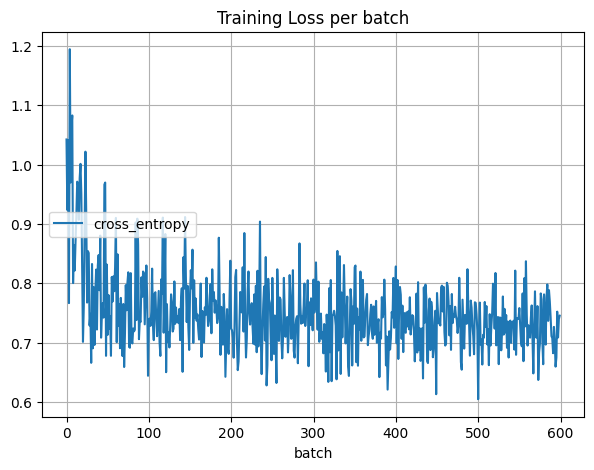

In [71]:
losses = { 'cross_entropy': [] }
for epoch in range(1):
    for b_start in range(0, len(training_rows), batch_size):
        mean_loss = 0
        for train_idx in range(b_start, b_start + batch_size):
            sentence = training_rows[train_idx][0]
            doc = nlp(sentence)
            vectors = np.stack([token.vector for token in doc], axis=1)  # This creates a 96 x len(doc) array
            
            input_tensor = torch.tensor(vectors).t().to(device)
            actual_output_tensor = senti_to_tensor(training_rows[train_idx][1]).to(device)

            rnn_output = model.forward(input_tensor)
            loss = criterion(rnn_output, actual_output_tensor)

            mean_loss += loss

        mean_loss /= float(batch_size)
        mean_loss.backward()

        with torch.no_grad():
            for _, param in model.named_parameters():
                param -= learning_rate*param.grad
            for _, param in model.named_parameters():
                param.grad.zero_()
            
        losses['cross_entropy'].append(mean_loss.item())
        live_plot(losses, title='Training Loss per batch')
        
            
            

In [73]:
losses['cross_entropy'][-1]

0.7452816367149353

In [83]:
total = len(testing_rows)
n_correct = 0 
with torch.no_grad():
    for i in range(total):
        sentence = testing_rows[i][0]
        doc = nlp(sentence)
        vectors = np.stack([token.vector for token in doc], axis=1)  # This creates a 96 x len(doc) array
        
        input_tensor = torch.tensor(vectors).t().to(device)
        actual_output_tensor = senti_to_tensor(testing_rows[i][1]).to(device)

        rnn_output = model.forward(input_tensor)
        soft_rnn_output = F.softmax(rnn_output, dim=0)
        rnn_pred = torch.argmax(soft_rnn_output).item()
        

        actual_label = torch.argmax(actual_output_tensor).item()

        
        # print(actual_label)
        # print(rnn_pred)
        
        if actual_label == rnn_pred:
            n_correct += 1


print('Accuracy = ', (100*n_correct) / total)

Accuracy =  49.85997199439888


In [84]:
# Using Pytorch inbuilt RNN

In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        
        # Define the first RNN layer
        self.rnn1 = nn.RNN(input_size, hidden_size1, num_layers=1, batch_first=True)
        # Define the second RNN layer
        self.rnn2 = nn.RNN(hidden_size1, hidden_size2, num_layers=1, batch_first=True)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        # Initialize hidden state for first layer
        h0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        # Forward propagate through the first RNN layer
        out, _ = self.rnn1(x, h0)
        
        # Initialize hidden state for second layer
        h1 = torch.zeros(1, x.size(0), self.hidden_size2).to(x.device)
        # Forward propagate through the second RNN layer
        out, _ = self.rnn2(out, h1)
        
        # Since we are interested in the output of the last time step
        out = out[:, -1, :]
        # Pass the output of the last RNN layer to the output layer
        out = self.fc(out)
        
        return out



In [127]:
input_size = 96  # Input size (feature size per word)
hidden_size1 = 100  # Size of the first hidden layer
hidden_size2 = 50  # Size of the second hidden layer
output_size = 2  # Output size (number of classes)


In [128]:
model = VanillaRNN(input_size, hidden_size1, hidden_size2, output_size)
model = model.to(device)

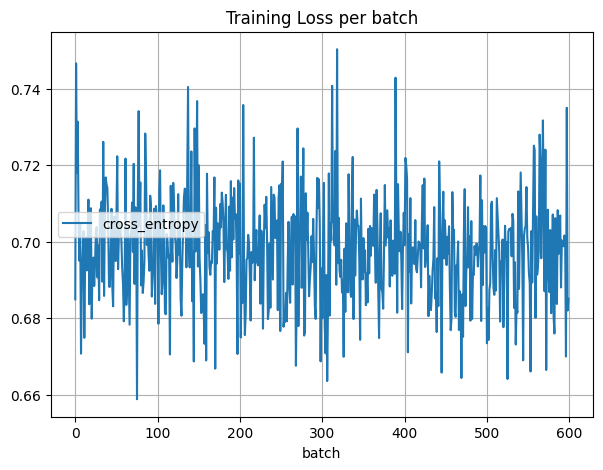

In [129]:
losses1 = { 'cross_entropy': [] }
for epoch in range(1):
    for b_start in range(0, len(training_rows), batch_size):
        mean_loss = 0
        for train_idx in range(b_start, b_start + batch_size):
            sentence = training_rows[train_idx][0]
            doc = nlp(sentence)
            vectors = np.stack([token.vector for token in doc], axis=1)  # This creates a 96 x len(doc) array
            
            input_tensor = torch.tensor(vectors).t().to(device)
            actual_output_tensor = senti_to_tensor(training_rows[train_idx][1]).to(device)
            
            input_tensor = input_tensor.reshape(1, input_tensor.shape[0], input_tensor.shape[1])
            
            rnn_output = model.forward(input_tensor)
            loss = criterion(rnn_output, actual_output_tensor.reshape(1,2))

            mean_loss += loss

        mean_loss /= torch.tensor(batch_size)
        mean_loss.backward()

        with torch.no_grad():
            for _, param in model.named_parameters():
                param -= learning_rate*param.grad
            for _, param in model.named_parameters():
                param.grad.zero_()
            
        losses1['cross_entropy'].append(mean_loss.item())
        live_plot(losses1, title='Training Loss per batch')
        
            
            

In [116]:
actual_output_tensor.shape

torch.Size([2])